In [469]:
import pandas as pd
import numpy as np
import math
from itertools import cycle
import statistics

#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import scikitplot as skplt
import sklearn as sk
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb

import statsmodels.api as sm
import statsmodels
from statsmodels.tools import eval_measures

from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [2]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [3]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

# Setup

## variables

In [4]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Functions

In [5]:
def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def mse(actual, predicted):
    return mean_squared_error(actual, predicted)

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def model_results(actual, predicted, rowcount, featurecount):
    print('r-squared: ', round(r2(actual, predicted),4))
    print('adj r-squared', round(adjr2(actual,predicted,rowcount, featurecount),4))
    print('mse: ', round(mse(actual, predicted),4))
    print('rmse: ', round(rmse(actual, predicted),4))
    print('rmse: ', eval_measures.rmse(actual,predicted,axis=0))

In [6]:
def get_fed_chair():
    df = pd.read_csv('./data/Fed_Chair.csv', parse_dates=['Start_Date','End_Date'])
    df['End_Date'].fillna(pd.Timestamp.now().normalize(), inplace=True)
    df = df[(df['Start_Date'] >= '1945-01-01')]
    return df

def fed_chair(df, chair_df):
    
    df.reset_index(inplace=True)

    df['chair_name'] = None
    for i, row in chair_df.iterrows():
        df['chair_name'] = df['chair_name'].where((df['DATE'] < row['Start_Date']) | (df['DATE'] > row['End_Date']), row['Name'] )
    
    df.set_index('DATE',inplace=True)
    return df

In [7]:
def get_recession():
    recession_df = pd.read_csv('./data/FRED_Recession_Bars.csv', parse_dates=['Peak_Date','Trough_Date'])
    return recession_df[(recession_df['Peak_Date'] >= '1945-01-01')]


def add_recession_feature(date, recession_df):
    for i,row in recession_df.iterrows():
        if row['Peak_Date'] <= date <= row['Trough_Date']:
            return True
    return False


In [422]:


def load_taylor():
    
    
    # Variables
    target_inf = 2
    full_emp = 5
    alpha = 0.5
    beta = 0.5
    
    
    t1_df = pdr.DataReader(['FEDFUNDS','UNRATE','TB3MS'], data_source, start_date)
    t1_df.index.rename('observation_date', inplace=True)
    t1_df.reset_index(inplace=True)
    print('t1_df:', t1_df.shape)

    gdpc1_df = pd.read_csv('./data/GDPC1.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpc1_df:', gdpc1_df.shape)
    gdppot_df = pd.read_csv('./data/GDPPOT.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdppot_df:', gdppot_df.shape)
    gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpdef_df:', gdpdef_df.shape)
    #fed_df = pd.read_csv('./data/FEDFUNDS.csv', parse_dates=['observation_date'], skiprows=10)
    #print('fed_df:', fed_df.shape)
    

    
    taylor_df = t1_df.merge(gdpc1_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                        .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date') 


    taylor_df.set_index('observation_date', inplace=True)
    taylor_df.index.rename('DATE', inplace=True)

    #taylor_df.dropna(inplace=True)
    taylor_df = taylor_df.resample('Q').mean()
    #taylor_df = taylor_df.resample('Q').mean()



    taylor_df['gap_inf'] = (taylor_df['GDPDEF_PC1'] - target_inf) 
    taylor_df['gap_gdp'] = (taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100
    taylor_df['gap_ue'] = (full_emp - taylor_df['UNRATE'])



    #taylor_df = pd.DataFrame()
    taylor_df['ffef_tr'] = taylor_df['GDPDEF_PC1'] + 2    \
                            + beta * taylor_df['gap_inf']   \
                            + alpha * taylor_df['gap_gdp']


    #
    taylor_df['ffef_tr2'] = taylor_df['GDPDEF_PC1'] + 2    \
                            + beta * taylor_df['gap_inf']   \
                            + alpha * taylor_df['gap_ue']
    

    #taylor_df.rename(columns={'observation_date':'DATE'}, inplace=True)
    
    taylor_df.reset_index(inplace=True)
    r_df = get_recession()
    taylor_df['recession_flag'] = taylor_df['DATE'].apply(add_recession_feature, args=(r_df,))
    taylor_df.set_index('DATE',inplace=True)
    
    f_df = get_fed_chair()
    taylor_df = fed_chair(taylor_df, f_df)
    
    
    taylor_df = taylor_df.query('DATE >= "1960-01-01" & DATE < "2023-09-30"')
    return taylor_df



def load_taylor2():
    
    # Variables
    target_inf = 2
    full_emp = 5
    alpha = 0.5
    beta = 0.5
    
    
    pcep_df = pd.read_csv('./data/PCEPILFE.csv', parse_dates=['observation_date'], skiprows=10)
    print('pcep_df:', pcep_df.shape)
    
    gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
    print('gdpdef_df:', gdpdef_df.shape)

    t1_df = pdr.DataReader(['FEDFUNDS','PCEPILFE','GDPC1','GDPPOT','UNRATE','TB3MS'], data_source, start_date)
    t1_df.index.rename('observation_date', inplace=True)
    t1_df.reset_index(inplace=True)

    t1_df = t1_df.merge(pcep_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date') 

    t1_df.set_index('observation_date', inplace=True)
    t1_df.index.rename('DATE', inplace=True)
    
    # calculate quarterly data
    t1_df = t1_df.resample('Q').mean()
    

    t1_df['rLR'] = t1_df['TB3MS'] - t1_df['GDPDEF_PC1']
    t1_df['GDPC1_log'] = t1_df['GDPC1'].apply(math.log)
    t1_df['GDPPOT_log'] = t1_df['GDPPOT'].apply(math.log)
    
    
    # Calculate Taylor Rules 1&2
    t1_df['gap_gdp'] = (t1_df['GDPC1_log'] - t1_df['GDPPOT_log'])
    t1_df['gap_ue'] = (full_emp - t1_df['UNRATE'])
    t1_df['gap_inf'] = (t1_df['PCEPILFE_CH1'] - target_inf)
    
    

    t1_df['ffef_tr'] = t1_df['rLR']  \
                            + t1_df['PCEPILFE_CH1']  \
                            + (alpha * t1_df['gap_gdp'])  \
                            + (beta * t1_df['gap_inf'])

    t1_df['ffef_tr2'] = t1_df['rLR']  \
                            + t1_df['PCEPILFE_CH1']  \
                            + (alpha * t1_df['gap_ue'])  \
                            + (beta * t1_df['gap_inf'])
    
    
    t1_df.reset_index(inplace=True)
    r_df = get_recession()
    t1_df['recession_flag'] = t1_df['DATE'].apply(add_recession_feature, args=(r_df,))
    t1_df.set_index('DATE',inplace=True)
    
    f_df = get_fed_chair()
    t1_df = fed_chair(t1_df, f_df)
    

    print('t1_df:', t1_df.shape)
    #t1_df.dropna(inplace=True)
    #t1_df.sort_index(inplace=True)
    
    t1_df = t1_df.query('DATE >= "1960-01-01" & DATE < "2023-09-30"')
    
    return t1_df



def load_misery():
    
    t_df = pdr.DataReader(['FEDFUNDS','CPIAUCSL', 'UNRATE'], data_source, start_date)
    t_df.dropna(inplace=True)
    print('t_df:', t_df.shape)

    u_df = pd.read_csv('./data/CPIAUCSL_PC1.csv', parse_dates=['DATE'])
    u_df.set_index('DATE', inplace=True)
    print('u_df:', u_df.shape)

    misery_df = pd.merge(t_df,u_df, left_index=True, right_index=True )
    misery_df['m_index'] = (misery_df['CPIAUCSL_PC1']) + misery_df['UNRATE']
    print('misery_df:', misery_df.shape)  
    
    return misery_df



def time_split(df):
    t_df = df.copy()

    # Split Data
    splt_index = round(t_df.shape[0] * 0.8)
    train_df = t_df[:splt_index]
    print('train_df: ' , train_df.shape)

    end_index = splt_index - t_df.shape[0]
    test_df = t_df[end_index:]
    print('test_df: ' , test_df.shape)
    
    return train_df, test_df

In [420]:
t1_df = pdr.DataReader(['FEDFUNDS','UNRATE','TB3MS'], data_source, start_date)
t1_df.index.rename('observation_date', inplace=True)
t1_df.reset_index(inplace=True)
print('t1_df:', t1_df.shape)

gdpc1_df = pd.read_csv('./data/GDPC1.csv', parse_dates=['observation_date'], skiprows=10)
print('gdpc1_df:', gdpc1_df.shape)
gdppot_df = pd.read_csv('./data/GDPPOT.csv', parse_dates=['observation_date'], skiprows=10)
print('gdppot_df:', gdppot_df.shape)
gdpdef_df = pd.read_csv('./data/GDPDEF.csv', parse_dates=['observation_date'], skiprows=10)
print('gdpdef_df:', gdpdef_df.shape)
real_df = pd.read_csv('./data/Holston_Laubach_Williams_real_time_estimates.csv', parse_dates=['Date'], skiprows=5)
real_df.rename(columns={'Date':'observation_date'}, inplace=True)
print('real_df:', real_df.shape)



taylor_df = t1_df.merge(gdpc1_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                    .merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                    .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date')   \
                    .merge(real_df, how='outer', left_on='observation_date', right_on='observation_date') 


#taylor_df = gdpc1_df.merge(gdppot_df, how='outer', left_on='observation_date', right_on='observation_date')   \
#                    .merge(gdpdef_df, how='outer', left_on='observation_date', right_on='observation_date')   \
#                    .merge(t1_df, how='outer', left_on='observation_date', right_on='observation_date') 


taylor_df.set_index('observation_date', inplace=True)
taylor_df.index.rename('DATE', inplace=True)

#taylor_df.dropna(inplace=True)
taylor_df = taylor_df.resample('Q').mean()
#taylor_df = taylor_df.resample('Q').mean()



taylor_df['gap_inf'] = (taylor_df['GDPDEF_PC1'] - target_inf) 
taylor_df['gap_gdp'] = (taylor_df['GDPC1'] - taylor_df['GDPPOT']) / taylor_df['GDPPOT'] * 100
taylor_df['gap_ue'] = (full_emp - taylor_df['UNRATE'])



#taylor_df = pd.DataFrame()
taylor_df['ffef_tr'] = taylor_df['GDPDEF_PC1'] + 2    \
                        + beta * taylor_df['gap_inf']   \
                        + alpha * taylor_df['gap_gdp']


#
taylor_df['ffef_tr2'] = taylor_df['GDPDEF_PC1'] + 2    \
                        + beta * taylor_df['gap_inf']   \
                        + alpha * taylor_df['gap_ue']


taylor_df = taylor_df.query('DATE >= "1960-01-01" & DATE < "2023-09-30"')

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
real_df: (250, 4)


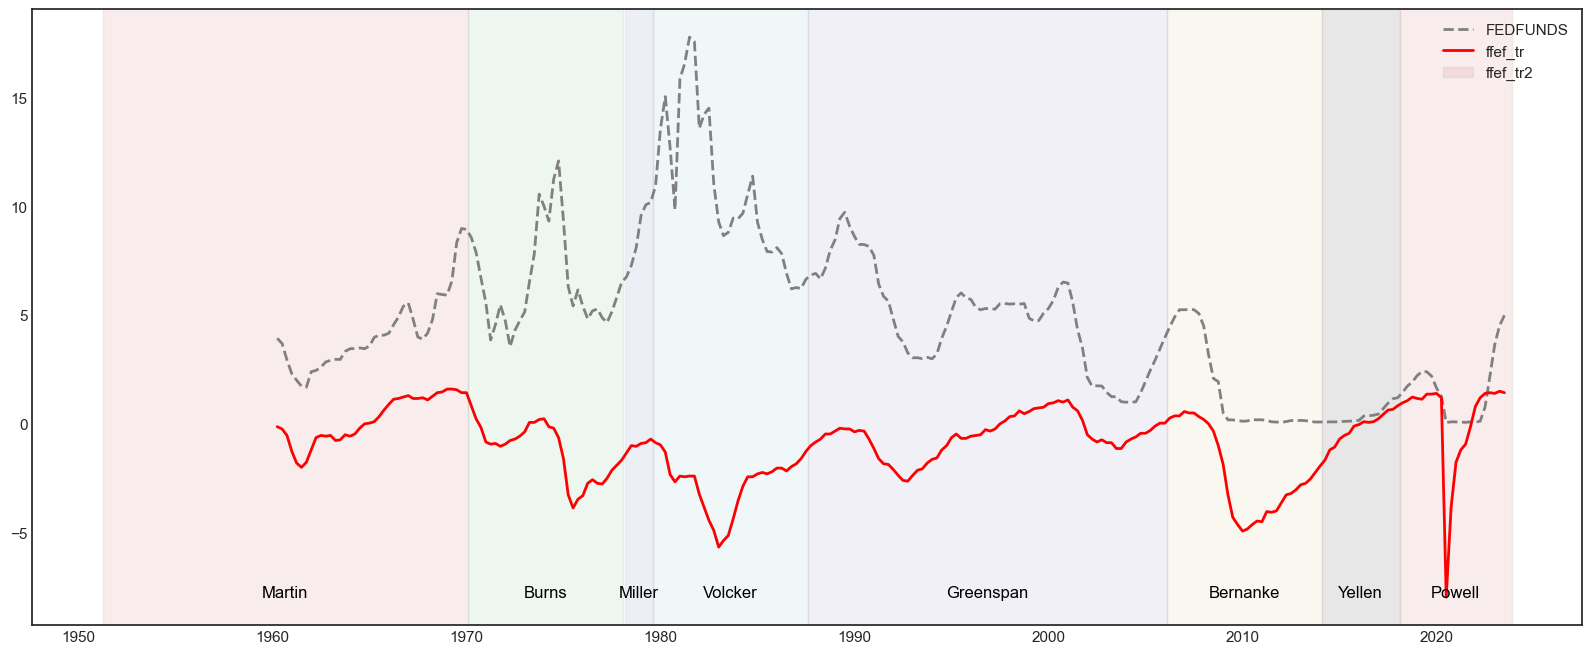

In [471]:
cycol = cycle('rgbcmyk')
min_value = t_df[['FEDFUNDS','gap_ue','ffef_tr']].values.min()


#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor_df

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
#ax.plot(t_df.index, t_df['ffef_tr'], color='blue',linewidth=2)
#ax.plot(t_df.index, t_df['ffef_tr2'], color='red',linewidth=2)
#ax.plot(t_df.index, t_df['Real_Interest_Rate'], color='red',linewidth=2)
#ax.plot(t_df.index, t_df['GDPDEF_PC1'], color='red',linewidth=2)

ax.plot(t_df.index, t_df['gap_ue'], color='red',linewidth=2)
#ax.plot(t_df.index, t_df['UNRATE'], color='blue',linewidth=2)


# Plotting recession bars
#for i,row in r_df.iterrows():
#    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    
    
# Plotting recession bars
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=12, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","ffef_tr",'ffef_tr2'])
#plt.legend()
plt.grid(False)
plt.show()

In [466]:
t_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'gap_inf', 'gap_gdp', 'gap_ue', 'ffef_tr', 'ffef_tr2', 'recession_flag',
       'chair_name'],
      dtype='object')

In [467]:
t_df[['FEDFUNDS','gap_ue','ffef_tr']].values.min()

-7.966666666666667

In [458]:
from datetime import datetime, timedelta

# Example timestamps
timestamp1 = datetime(2023, 11, 10, 10, 30, 0)  # Earlier timestamp
timestamp2 = datetime(2023, 11, 20, 15, 45, 0)  # Later timestamp

# Calculate the midpoint between the two timestamps
midpoint = timestamp1 + (timestamp2 - timestamp1) / 2

print(f"The midpoint between {timestamp1} and {timestamp2} is: {midpoint}")

The midpoint between 2023-11-10 10:30:00 and 2023-11-20 15:45:00 is: 2023-11-15 13:07:30


In [402]:
chair_df.columns

Index(['Name', 'Full_Name', 'Start_Date', 'End_Date', 'Title'], dtype='object')

In [411]:
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'Growth_g', 'Real_Interest_Rate', 'Output_Gap', 'gap_inf', 'gap_gdp',
       'gap_ue', 'ffef_tr', 'ffef_tr2'],
      dtype='object')

In [423]:
taylor_df = load_taylor()

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)


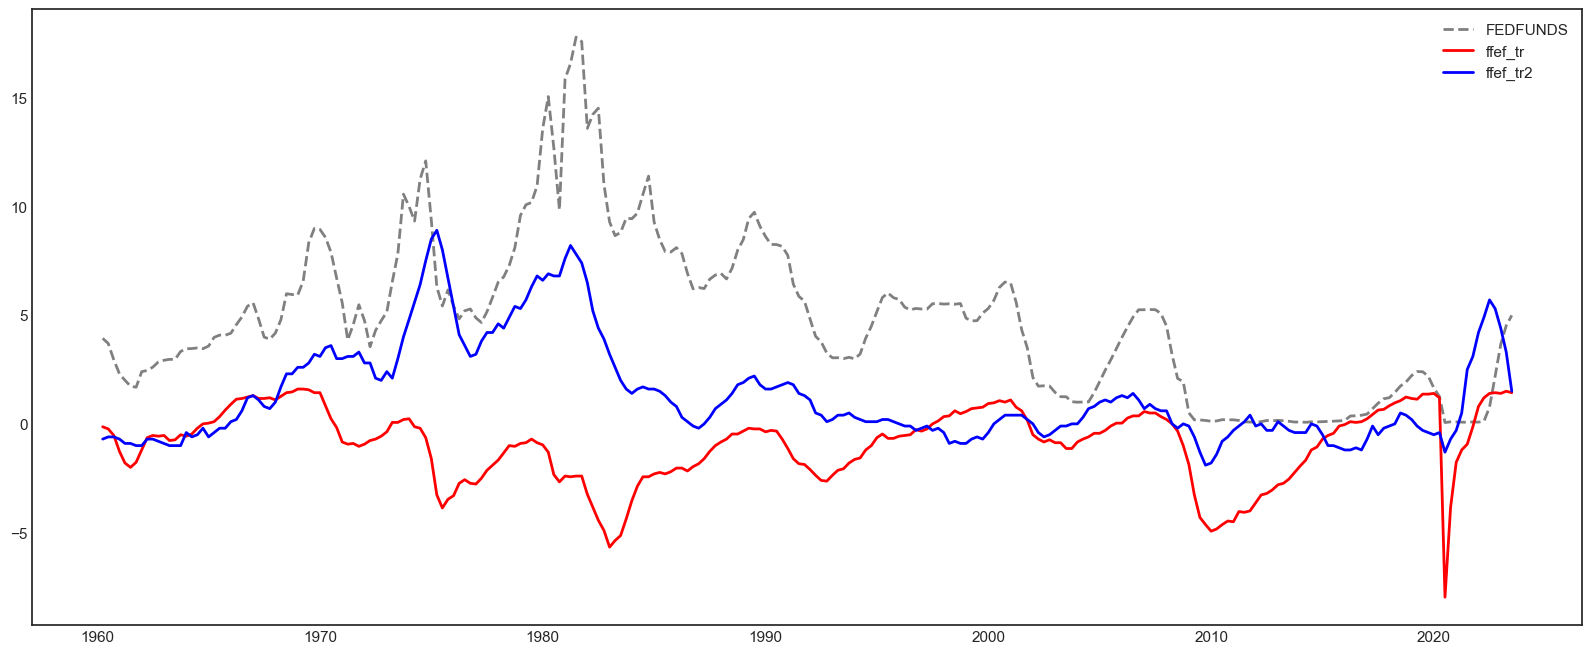

In [441]:
cycol = cycle('rgbcmyk')


#t_df = taylor_df.query('DATE >= "2000-01-01" & DATE < "2020-01-01"')
t_df = taylor_df.query('DATE >= "1960-01-01"')
#t_df = taylor_df

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
#ax.plot(t_df.index, t_df['ffef_tr'], color='blue',linewidth=2)
#ax.plot(t_df.index, t_df['ffef_tr2'], color='red',linewidth=2)
#ax.plot(t_df.index, t_df['Real_Interest_Rate'], color='red',linewidth=2)
#ax.plot(t_df.index, t_df['GDPDEF_PC1'], color='red',linewidth=2)

ax.plot(t_df.index, t_df['gap_ue'], color='red',linewidth=2)
ax.plot(t_df.index, t_df['gap_inf'], color='blue',linewidth=2)


# Plotting recession bars
#for i,row in r_df.iterrows():
#    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    
    
# Plotting recession bars
#for i,row in chair_df.query('End_Date >= "2000-01-01"').iterrows():
#    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1)
    
    
ax.legend(["FEDFUNDS","ffef_tr",'ffef_tr2'])
plt.grid(False)
plt.show()

In [427]:
model_results(taylor_df['FEDFUNDS'], taylor_df['ffef_tr'], taylor_df.shape[0], 2 )

r-squared:  -1.156
adj r-squared -1.1645
mse:  28.8847
rmse:  5.3745
rmse:  5.374450856644936


In [426]:
model_results(taylor_df['FEDFUNDS'], taylor_df['ffef_tr2'], taylor_df.shape[0], 2 )

r-squared:  0.3295
adj r-squared 0.3268
mse:  8.9837
rmse:  2.9973
rmse:  2.9972814745983154


In [354]:
tailor2_df = load_taylor2()

pcep_df: (765, 2)
gdpdef_df: (302, 2)
t1_df: (336, 18)


In [358]:
tailor2_df.columns

Index(['FEDFUNDS', 'PCEPILFE', 'GDPC1', 'GDPPOT', 'UNRATE', 'TB3MS',
       'PCEPILFE_CH1', 'GDPDEF_PC1', 'rLR', 'GDPC1_log', 'GDPPOT_log',
       'gap_gdp', 'gap_ue', 'gap_inf', 'ffef_tr', 'ffef_tr2', 'recession_flag',
       'chair_name'],
      dtype='object')

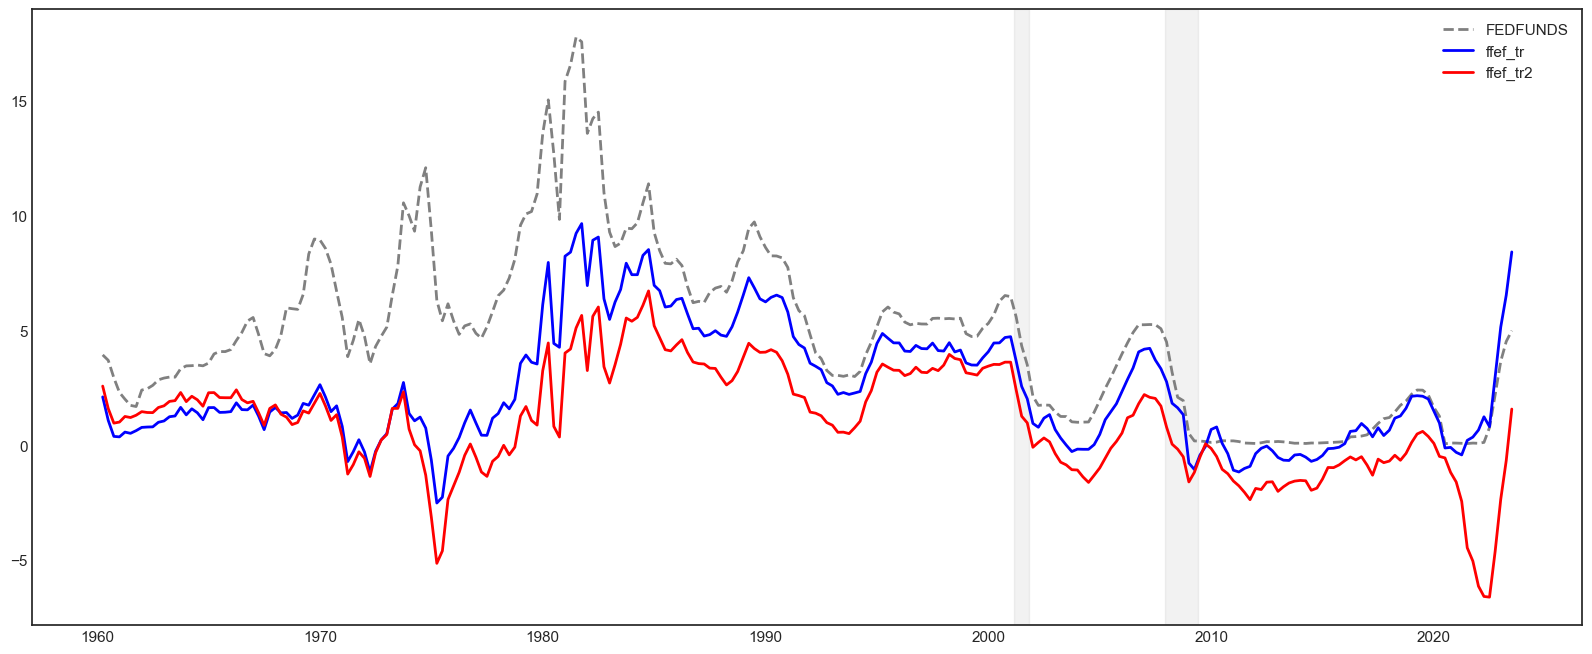

In [365]:
#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = tailor2_df

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr'], color='blue',linewidth=2)
#ax.plot(t_df.index, t_df['ffef_tr2'], color='red',linewidth=2)

ax.plot(t_df.index, t_df['rLR'], color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    
ax.legend(["FEDFUNDS","ffef_tr",'ffef_tr2'])
plt.grid(False)
plt.show()

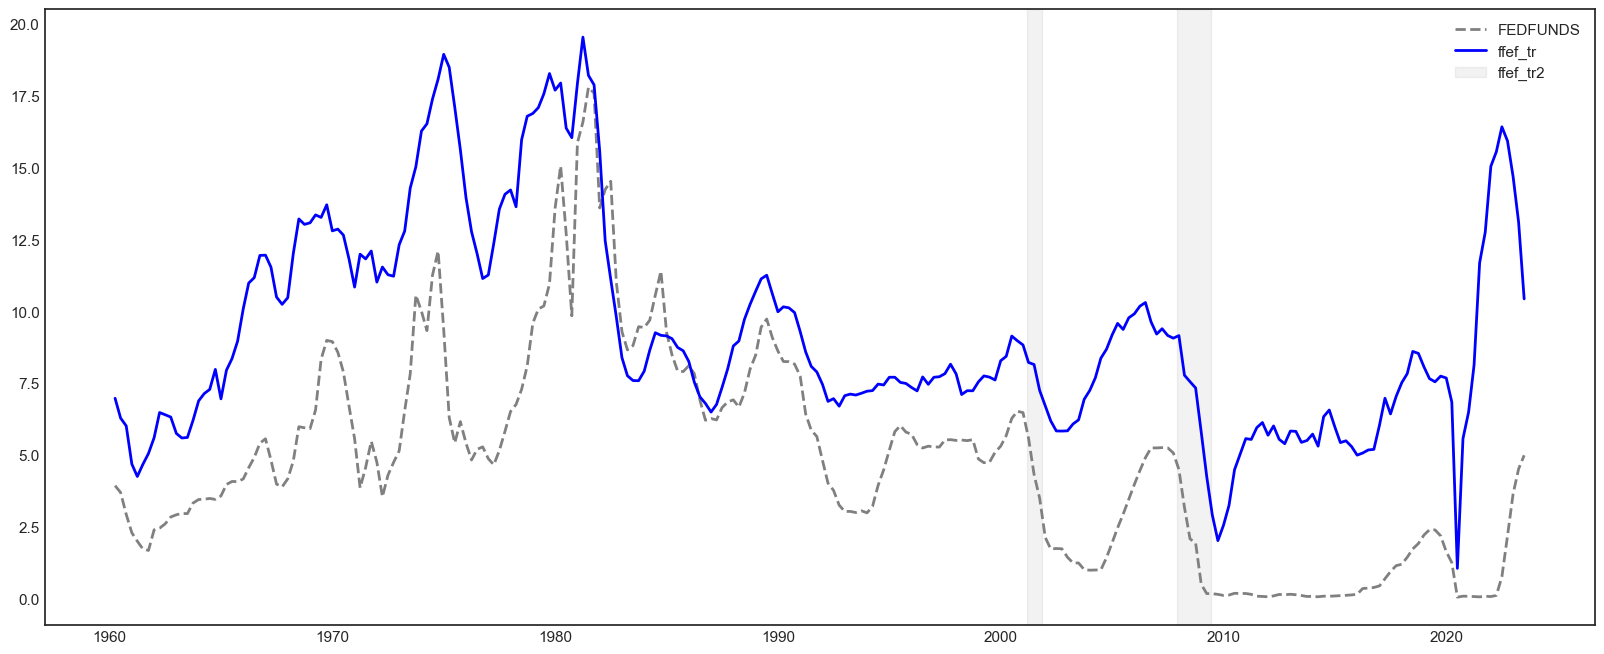

In [346]:

#t_df = taylor_df.query('DATE >= "1999-01-01" & DATE < "2020-01-01"')
t_df = taylor_df

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr'], color='blue',linewidth=2)
#ax.plot(t_df.index, t_df['ffef_tr2'], color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    
ax.legend(["FEDFUNDS","ffef_tr",'ffef_tr2'])
plt.grid(False)
plt.show()

# Dataset FRED Data

In [303]:
taylor_df = load_taylor()
taylor_df.tail(30)

t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)


,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,UNRATE,TB3MS,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,
2020-02-01,NaN,NaN,NaN,1.58,3.5,1.52,NaN,NaN,-1.5,NaN,NaN,True,Powell
2020-03-01,NaN,NaN,NaN,0.65,4.4,0.29,NaN,NaN,-0.6,NaN,NaN,True,Powell
2020-05-01,NaN,NaN,NaN,0.05,13.2,0.13,NaN,NaN,8.2,NaN,NaN,False,Powell
2020-06-01,NaN,NaN,NaN,0.08,11.0,0.16,NaN,NaN,6.0,NaN,NaN,False,Powell
2020-08-01,NaN,NaN,NaN,0.10,8.4,0.10,NaN,NaN,3.4,NaN,NaN,False,Powell
2020-09-01,NaN,NaN,NaN,0.09,7.9,0.11,NaN,NaN,2.9,NaN,NaN,False,Powell
2020-11-01,NaN,NaN,NaN,0.09,6.7,0.09,NaN,NaN,1.7,NaN,NaN,False,Powell
2020-12-01,NaN,NaN,NaN,0.09,6.7,0.09,NaN,NaN,1.7,NaN,NaN,False,Powell
2021-02-01,NaN,NaN,NaN,0.08,6.2,0.04,NaN,NaN,1.2,NaN,NaN,False,Powell


In [301]:
taylor_df.tail(30)

,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,UNRATE,TB3MS,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,
2020-02-01,NaN,NaN,NaN,1.58,3.5,1.52,NaN,NaN,-1.5,NaN,NaN,True,Powell
2020-03-01,NaN,NaN,NaN,0.65,4.4,0.29,NaN,NaN,-0.6,NaN,NaN,True,Powell
2020-05-01,NaN,NaN,NaN,0.05,13.2,0.13,NaN,NaN,8.2,NaN,NaN,False,Powell
2020-06-01,NaN,NaN,NaN,0.08,11.0,0.16,NaN,NaN,6.0,NaN,NaN,False,Powell
2020-08-01,NaN,NaN,NaN,0.10,8.4,0.10,NaN,NaN,3.4,NaN,NaN,False,Powell
2020-09-01,NaN,NaN,NaN,0.09,7.9,0.11,NaN,NaN,2.9,NaN,NaN,False,Powell
2020-11-01,NaN,NaN,NaN,0.09,6.7,0.09,NaN,NaN,1.7,NaN,NaN,False,Powell
2020-12-01,NaN,NaN,NaN,0.09,6.7,0.09,NaN,NaN,1.7,NaN,NaN,False,Powell
2021-02-01,NaN,NaN,NaN,0.08,6.2,0.04,NaN,NaN,1.2,NaN,NaN,False,Powell


In [10]:
misery_df = load_misery()
misery_df

t_df: (832, 3)
u_df: (909, 1)
misery_df: (831, 5)


,FEDFUNDS,CPIAUCSL,UNRATE,CPIAUCSL_PC1,m_index
DATE,,,,,
1954-07-01,0.80,26.860,5.8,0.26129,6.06129
1954-08-01,1.22,26.850,6.0,0.00000,6.00000
1954-09-01,1.07,26.810,6.1,-0.29751,5.80249
1954-10-01,0.85,26.720,5.7,-0.85343,4.84657
1954-11-01,0.83,26.780,5.3,-0.26071,5.03929
...,...,...,...,...,...
2023-05-01,5.06,303.294,3.7,4.12884,7.82884
2023-06-01,5.08,303.841,3.6,3.09200,6.69200
2023-07-01,5.12,304.348,3.5,3.29908,6.79908


In [11]:
recession_df = get_recession()
recession_df

,Peak_Date,Trough_Date
21,1945-02-01,1945-10-01
22,1948-11-01,1949-10-01
23,1953-07-01,1954-05-01
24,1957-08-01,1958-04-01
25,1960-04-01,1961-02-01
26,1969-12-01,1970-11-01
27,1973-11-01,1975-03-01
28,1980-01-01,1980-07-01
29,1981-07-01,1982-11-01
30,1990-07-01,1991-03-01


In [12]:
chair_df = get_fed_chair()
chair_df

,Name,Full_Name,Start_Date,End_Date,Title
7,McCabe,Thomas B. McCabe,1948-04-15,1951-03-31,Chairman of the Board of Governors of the Fede...
8,Martin,"William McChesney Martin, Jr.",1951-04-02,1970-01-31,Chairman of the Board of Governors of the Fede...
9,Burns,Arthur F. Burns,1970-02-01,1978-01-31,Chairman of the Board of Governors of the Fede...
10,Miller,G. William Miller,1978-03-08,1979-08-06,Chairman of the Board of Governors of the Fede...
11,Volcker,Paul A. Volcker,1979-08-06,1987-08-11,Chairman of the Board of Governors of the Fede...
12,Greenspan,Alan Greenspan,1987-08-11,2006-01-31,Chairman of the Board of Governors of the Fede...
13,Bernanke,Ben S. Bernanke,2006-02-01,2014-01-31,Chairman of the Board of Governors of the Fede...
14,Yellen,Janet L. Yellen,2014-02-03,2018-02-03,Chair of the Board of Governors of the Federal...
15,Powell,Jerome H. Powell,2018-02-05,2023-11-16,Chair of the Board of Governors of the Federal...


# Taylor Rule

In [165]:
taylor_df2 = load_taylor2()

#t_df = taylor_df.query('index > "2005-01-01"')
#r_df = recession_df.query('Peak_Date > "2005-01-01"')
t_df = taylor_df2.query('index > "2000-01-01" & index < "2019-01-01"')
r_df = recession_df.query('Peak_Date > "2000-01-01" & Peak_Date < "2019-01-01"')

pcep_df: (765, 2)
gdpdef_df: (302, 2)
t1_df: (336, 18)


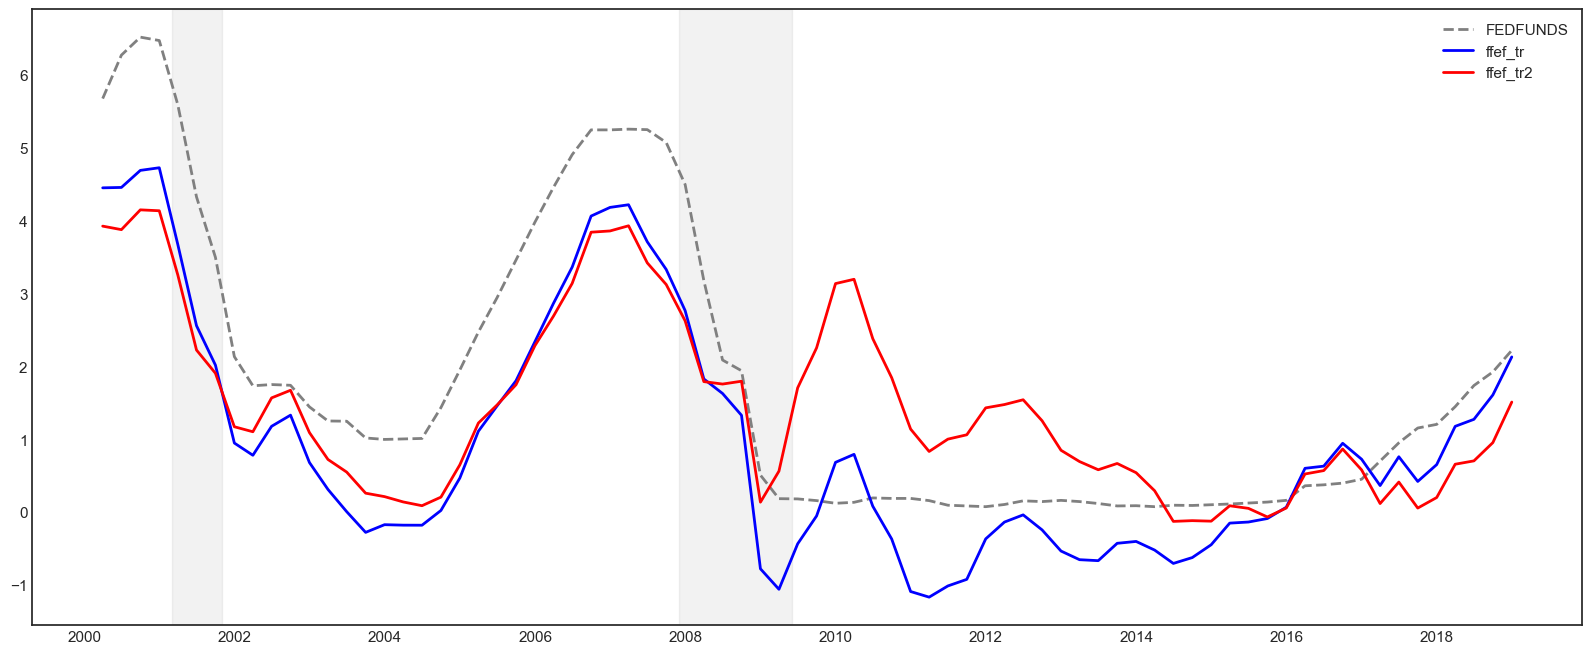

In [167]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr'], color='blue',linewidth=2)
ax.plot(t_df.index, t_df['ffef_tr2'], color='red',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    
ax.legend(["FEDFUNDS","ffef_tr",'ffef_tr2'])
plt.grid(False)
plt.show()

# Calculating Taylor

In [15]:
f1_df = taylor_df
f1_df

,GDPC1,GDPPOT,GDPDEF_PC1,FEDFUNDS,ffef_tr,gap_inf,gap_gdp,recession_flag,chair_name
DATE,,,,,,,,,
1954-07-01,2880.482,2727.099666,0.7,0.80,4.862188,-0.65,2.812188,False,Martin
1954-10-01,2936.852,2743.726730,0.8,0.85,5.719397,-0.60,3.519397,False,Martin
1955-01-01,3020.746,2760.136280,1.0,1.39,7.220957,-0.50,4.720957,False,Martin
1955-04-01,3069.910,2777.950765,1.3,1.43,8.204939,-0.35,5.254939,False,Martin
1955-07-01,3111.379,2795.471543,1.9,1.68,9.500343,-0.05,5.650343,False,Martin
...,...,...,...,...,...,...,...,...,...
2022-04-01,21708.160,20153.810000,7.7,0.33,16.406219,2.85,3.856219,False,Powell
2022-07-01,21851.134,20245.660000,7.3,1.68,15.914983,2.65,3.964983,False,Powell
2022-10-01,21989.981,20334.210000,6.4,3.08,14.671392,2.20,4.071392,False,Powell


In [16]:
pcep_df = pd.read_csv('./data/PCEPILFE.csv', parse_dates=['observation_date'], skiprows=10)
print('pcep_df:', pcep_df.shape)

pcep_df: (765, 2)


In [17]:
pcep_df

,observation_date,PCEPILFE_CH1
0,1960-01-01,0.321
1,1960-02-01,0.339
2,1960-03-01,0.322
3,1960-04-01,0.312
4,1960-05-01,0.319
...,...,...
760,2023-05-01,5.328
761,2023-06-01,4.892
762,2023-07-01,4.909
763,2023-08-01,4.425


In [18]:
pcep_df = pd.read_csv('./data/PCEPILFE.csv', parse_dates=['observation_date'], skiprows=10)
print('pcep_df:', pcep_df.shape)

t1_df = pdr.DataReader(['FEDFUNDS','PCEPILFE','GDPC1','GDPPOT','REAINTRATREARAT1MO','UNRATE'], data_source, start_date)
t1_df.index.rename('observation_date', inplace=True)
t1_df.reset_index(inplace=True)

t1_df = t1_df.merge(pcep_df, how='outer', left_on='observation_date', right_on='observation_date')


t1_df.set_index('observation_date', inplace=True)
t1_df.index.rename('DATE', inplace=True)

t1_df['GDPC1_log'] = taylor_df['GDPC1'].apply(math.log)
t1_df['GDPPOT_log'] = taylor_df['GDPPOT'].apply(math.log)

#t1_df.dropna(inplace=True)
#t1_df = t1_df.query('index > "1999-01-01"')
print('t1_df:', t1_df.shape)
t1_df.dropna(inplace=True)
t1_df.head(5)

pcep_df: (765, 2)
t1_df: (915, 9)


,FEDFUNDS,PCEPILFE,GDPC1,GDPPOT,REAINTRATREARAT1MO,UNRATE,PCEPILFE_CH1,GDPC1_log,GDPPOT_log
DATE,,,,,,,,,
1982-01-01,13.22,42.829,7295.631,7202.119830,2.464018,8.6,2.968,8.895031,8.882131
1982-04-01,14.94,43.353,7328.912,7255.183995,8.803434,9.3,2.720,8.899582,8.889472
1982-07-01,12.59,44.092,7300.896,7309.422617,7.161898,9.8,2.727,8.895752,8.896920
1982-10-01,9.71,44.741,7303.817,7365.185870,2.752972,10.4,2.576,8.896152,8.904520
1983-01-01,8.68,45.357,7400.066,7421.653951,4.469162,10.4,2.528,8.909244,8.912157


In [19]:
target_inf = 2
full_emp = 5
alpha = 0.5
beta = 0.5

In [20]:
t1_df['gap_gdp'] = alpha * (t1_df['GDPC1_log'] - t1_df['GDPPOT_log'])
t1_df['ue_gdp'] = alpha * (t1_df['UNRATE'] - full_emp)
t1_df['gap_inf'] = beta * (t1_df['PCEPILFE_CH1'] - target_inf)

t1_df['ffef_tr'] = t1_df['REAINTRATREARAT1MO']  \
                        + t1_df['PCEPILFE_CH1']  \
                        + t1_df['gap_gdp']  \
                        + t1_df['gap_inf']

t1_df['ffef_tr2'] = t1_df['REAINTRATREARAT1MO']  \
                        + t1_df['PCEPILFE_CH1']  \
                        + t1_df['ue_gdp']  \
                        + t1_df['gap_inf']

t1_df.head()

,FEDFUNDS,PCEPILFE,GDPC1,GDPPOT,REAINTRATREARAT1MO,UNRATE,PCEPILFE_CH1,GDPC1_log,GDPPOT_log,gap_gdp,ue_gdp,gap_inf,ffef_tr,ffef_tr2
DATE,,,,,,,,,,,,,,
1982-01-01,13.22,42.829,7295.631,7202.119830,2.464018,8.6,2.968,8.895031,8.882131,0.006450,1.80,0.4840,5.922468,7.716018
1982-04-01,14.94,43.353,7328.912,7255.183995,8.803434,9.3,2.720,8.899582,8.889472,0.005055,2.15,0.3600,11.888490,14.033434
1982-07-01,12.59,44.092,7300.896,7309.422617,7.161898,9.8,2.727,8.895752,8.896920,-0.000584,2.40,0.3635,10.251814,12.652398
1982-10-01,9.71,44.741,7303.817,7365.185870,2.752972,10.4,2.576,8.896152,8.904520,-0.004184,2.70,0.2880,5.612788,8.316972
1983-01-01,8.68,45.357,7400.066,7421.653951,4.469162,10.4,2.528,8.909244,8.912157,-0.001457,2.70,0.2640,7.259705,9.961162


In [21]:
#t2_df = taylor_df.query('index > "2005-01-01"')
r_df = recession_df.query('Peak_Date > "1982-01-01"')

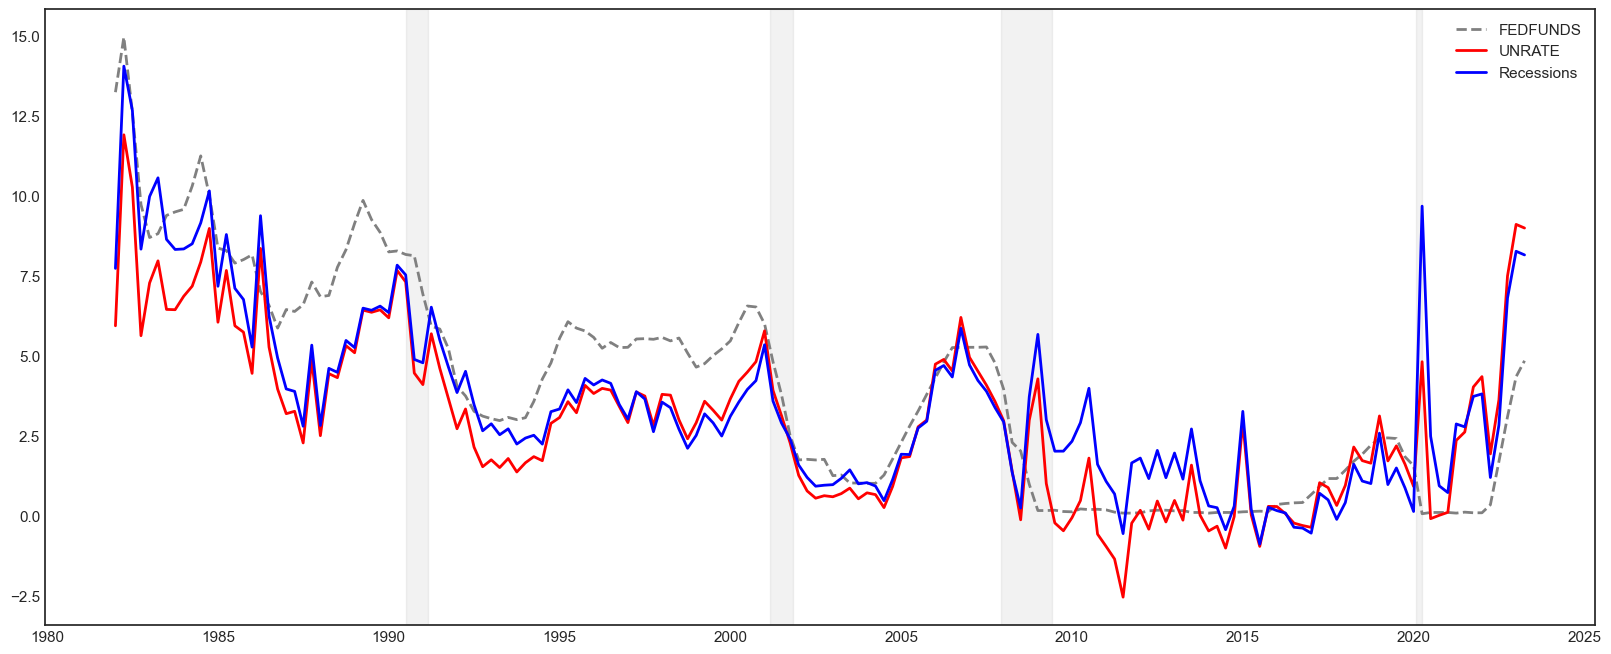

In [22]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(t1_df.index, t1_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=2)
ax.plot(t1_df.index, t1_df['ffef_tr'], color='red',linewidth=2)
ax.plot(t1_df.index, t1_df['ffef_tr2'], color='blue',linewidth=2)

# Plotting recession bars
for i,row in r_df.iterrows():
    plt.axvspan(row['Peak_Date'], row['Trough_Date'], color='gray', alpha=0.1)
    
ax.legend(["FEDFUNDS","UNRATE",'Recessions'])
plt.grid(False)
plt.show()

In [23]:
model_results(t1_df['FEDFUNDS'], t1_df['ffef_tr'], t1_df.shape[0], 2 )

r-squared:  0.6343
adj r-squared 0.632
mse:  4.0345
rmse:  2.0086
rmse:  2.008611888312051


In [24]:
model_results(t1_df['FEDFUNDS'], t1_df['ffef_tr2'], t1_df.shape[0], 2 )

r-squared:  0.6428
adj r-squared 0.6406
mse:  3.9402
rmse:  1.985
rmse:  1.9849995327927905


# Stats Model

In [628]:
taylor_df = load_taylor()
#taylor_df.dropna(subset=['GDPC1'], inplace=True)
#taylor_df = taylor_df.query('DATE >= "1960-01-01" & DATE < "2023-09-30"')
taylor_df = taylor_df.query('DATE >= "1960-01-01" & DATE < "2007-01-01"')


t1_df: (1006, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)


In [629]:
taylor_df.tail(20)

,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,
2002-03-31,1.733333,5.700000,1.720000,14372.785,13614.639972,1.6,-0.4,5.568601,-0.700000,6.184301,3.050000,False,Greenspan
2002-06-30,1.750000,5.833333,1.713333,14460.848,13710.495613,1.4,-0.6,5.472832,-0.833333,5.836416,2.683333,False,Greenspan
2002-09-30,1.740000,5.733333,1.643333,14519.633,13806.648385,1.5,-0.5,5.164067,-0.733333,5.832034,2.883333,False,Greenspan
2002-12-31,1.443333,5.866667,1.333333,14537.580,13900.715186,1.7,-0.3,4.581526,-0.866667,5.840763,3.116667,False,Greenspan
2003-03-31,1.250000,5.866667,1.156667,14614.141,13990.858185,1.9,-0.1,4.454929,-0.866667,6.077465,3.416667,False,Greenspan
2003-06-30,1.246667,6.133333,1.040000,14743.567,14076.165745,1.9,-0.1,4.741357,-1.133333,6.220678,3.283333,False,Greenspan
2003-09-30,1.016667,6.133333,0.930000,14988.782,14157.509217,2.0,0.0,5.871603,-1.133333,6.935802,3.433333,False,Greenspan
2003-12-31,0.996667,5.833333,0.916667,15162.760,14238.517253,2.0,0.0,6.491145,-0.833333,7.245572,3.583333,False,Greenspan
2004-03-31,1.003333,5.700000,0.916667,15248.680,14322.502791,2.3,0.3,6.466588,-0.700000,7.683294,4.100000,False,Greenspan


quarterly_df = taylor_df.resample('Q').mean()
#quarterly_df = quarterly_df.set_index(quarterly_df.index - pd.offsets.QuarterBegin(startingMonth=1))
quarterly_df.head(20)

In [630]:
taylor_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 1960-03-31 to 2006-12-31
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FEDFUNDS        188 non-null    float64
 1   UNRATE          188 non-null    float64
 2   TB3MS           188 non-null    float64
 3   GDPC1           188 non-null    float64
 4   GDPPOT          188 non-null    float64
 5   GDPDEF_PC1      188 non-null    float64
 6   gap_inf         188 non-null    float64
 7   gap_gdp         188 non-null    float64
 8   gap_ue          188 non-null    float64
 9   ffef_tr         188 non-null    float64
 10  ffef_tr2        188 non-null    float64
 11  recession_flag  188 non-null    bool   
 12  chair_name      188 non-null    object 
dtypes: bool(1), float64(11), object(1)
memory usage: 19.3+ KB


In [631]:
taylor_df[taylor_df['ffef_tr'].isnull()]

,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,


In [632]:
train_df, test_df = time_split(taylor_df)

train_df:  (150, 13)
test_df:  (38, 13)


In [633]:
taylor_df.describe()

,FEDFUNDS,UNRATE,TB3MS,GDPC1,GDPPOT,GDPDEF_PC1,gap_inf,gap_gdp,gap_ue,ffef_tr,ffef_tr2
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,6.093901,5.873050,5.544078,8714.853064,8160.919458,3.721809,1.721809,6.864337,-0.873050,10.014881,6.146188
std,3.291601,1.443145,2.731089,3711.756295,3463.509188,2.388655,2.388655,2.469997,1.443145,3.546040,3.400555
min,0.996667,3.400000,0.916667,3470.278000,3255.290989,1.000000,-1.000000,-0.833229,-5.666667,4.253347,1.616667
25%,3.923333,4.958333,3.748333,5527.792000,5225.612537,1.975000,-0.025000,5.477179,-1.833333,7.352896,3.550000
50%,5.488333,5.683333,5.075000,7644.101000,7510.969705,3.100000,1.100000,6.682740,-0.683333,8.966091,5.166667
75%,7.938333,6.833333,7.013333,11328.393500,10615.421977,5.000000,3.000000,8.330480,0.041667,11.984551,8.129167
max,17.780000,10.666667,15.053333,16561.866000,15291.514447,10.900000,8.900000,13.351788,1.600000,19.523598,15.950000


In [634]:
X_train = train_df[['gap_inf', 'gap_ue','recession_flag','chair_name']]
y_train = train_df['FEDFUNDS']


X_test = test_df[['gap_inf', 'gap_ue','recession_flag','chair_name']]
y_test = test_df['FEDFUNDS']

In [635]:
# Initialize Imputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')

# Initialize Transformer / OneHotEncoder
cat_columns_lst = ['recession_flag','chair_name']
num_columns_lst = ['gap_inf', 'gap_ue']


ohe_categories = list()
for c in cat_columns_lst:
    ohe_categories.append(list(X_train[c].unique()))
    
ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                   sparse_output=False, handle_unknown='ignore')

transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')



numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
categorical_transformer = Pipeline( steps=[('transformer',transformer)])

In [636]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns_lst),
        ("cat", categorical_transformer, cat_columns_lst),
    ]
)

preprocessor.fit_transform

In [637]:
X_train

,gap_inf,gap_ue,recession_flag,chair_name
DATE,,,,
1960-03-31,-0.7,-0.133333,False,Martin
1960-06-30,-0.6,-0.233333,True,Martin
1960-09-30,-0.6,-0.533333,True,Martin
1960-12-31,-0.7,-1.266667,True,Martin
1961-03-31,-0.9,-1.800000,False,Martin
...,...,...,...,...
1996-06-30,-0.1,-0.500000,False,Greenspan
1996-09-30,-0.3,-0.266667,False,Greenspan
1996-12-31,-0.2,-0.333333,False,Greenspan


In [638]:
t_fit = preprocessor.fit(X_train)

In [639]:
t_fit.get_feature_names_out()

array(['num__gap_inf', 'num__gap_ue',
       'cat__onehotencoder__recession_flag_True',
       'cat__onehotencoder__chair_name_Burns',
       'cat__onehotencoder__chair_name_Miller',
       'cat__onehotencoder__chair_name_Volcker',
       'cat__onehotencoder__chair_name_Greenspan'], dtype=object)

In [640]:
X_train_trf = t_fit.transform(X_train)

In [641]:
#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
X_train_trf.columns = t_fit.get_feature_names_out()
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)
X_train_trf

,num__gap_inf,num__gap_ue,cat__onehotencoder__recession_flag_True,cat__onehotencoder__chair_name_Burns,cat__onehotencoder__chair_name_Miller,cat__onehotencoder__chair_name_Volcker,cat__onehotencoder__chair_name_Greenspan
DATE,,,,,,,
1960-03-31,-0.7,-0.133333,0.0,0.0,0.0,0.0,0.0
1960-06-30,-0.6,-0.233333,1.0,0.0,0.0,0.0,0.0
1960-09-30,-0.6,-0.533333,1.0,0.0,0.0,0.0,0.0
1960-12-31,-0.7,-1.266667,1.0,0.0,0.0,0.0,0.0
1961-03-31,-0.9,-1.800000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1996-06-30,-0.1,-0.500000,0.0,0.0,0.0,0.0,1.0
1996-09-30,-0.3,-0.266667,0.0,0.0,0.0,0.0,1.0
1996-12-31,-0.2,-0.333333,0.0,0.0,0.0,0.0,1.0


In [642]:
y_train

DATE
1960-03-31    3.933333
1960-06-30    3.696667
1960-09-30    2.936667
1960-12-31    2.296667
1961-03-31    2.003333
                ...   
1996-06-30    5.243333
1996-09-30    5.306667
1996-12-31    5.280000
1997-03-31    5.276667
1997-06-30    5.523333
Name: FEDFUNDS, Length: 150, dtype: float64

In [643]:
X_train_const = sm.add_constant(X_train_trf)
X_train_const

,const,num__gap_inf,num__gap_ue,cat__onehotencoder__recession_flag_True,cat__onehotencoder__chair_name_Burns,cat__onehotencoder__chair_name_Miller,cat__onehotencoder__chair_name_Volcker,cat__onehotencoder__chair_name_Greenspan
DATE,,,,,,,,
1960-03-31,1.0,-0.7,-0.133333,0.0,0.0,0.0,0.0,0.0
1960-06-30,1.0,-0.6,-0.233333,1.0,0.0,0.0,0.0,0.0
1960-09-30,1.0,-0.6,-0.533333,1.0,0.0,0.0,0.0,0.0
1960-12-31,1.0,-0.7,-1.266667,1.0,0.0,0.0,0.0,0.0
1961-03-31,1.0,-0.9,-1.800000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1996-06-30,1.0,-0.1,-0.500000,0.0,0.0,0.0,0.0,1.0
1996-09-30,1.0,-0.3,-0.266667,0.0,0.0,0.0,0.0,1.0
1996-12-31,1.0,-0.2,-0.333333,0.0,0.0,0.0,0.0,1.0


In [644]:
ols_model = sm.OLS(y_train, X_train_const)
ols_result = ols_model.fit()

In [645]:
ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               FEDFUNDS   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     134.1
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           2.55e-59
Time:                        07:49:12   Log-Likelihood:                -239.57
No. Observations:                 150   AIC:                             495.1
Df Residuals:                     142   BIC:                             519.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        3.6230      0.197     18.349      0.000       3.233       4.013
num__gap_inf                                 0.8996      0.060     14.956      0.000       0.781       1.018
num__gap_ue                                  0.6795      0.094      7.209      0.000       0.493       0.866
cat__onehotencoder__recession_flag_True      1.3949      0.315      4.423      0.000       0.771       2.018
cat__onehotencoder__chair_name_Burns        -0.4451      0.402     -1.107      0.270      -1.240       0.350
cat__onehotencoder__chair_name_Miller        0.9028      0.636      1.420      0.158      -0.354       2.160
cat__onehotencoder__chair_name_Volcker       5.6198      0.449     12.527      0.000       4.733       6.507
cat__onehotencoder__chair_name_Greenspan     2.1692      0.301      7.203      0.000       1.574       2.765
==============================================================================
Omnibus:                        4.469   Durbin-Watson:                   0.761
Prob(Omnibus):                  0.107   Jarque-Bera (JB):                5.457
Skew:                          -0.130   Prob(JB):                       0.0653
Kurtosis:                       3.898   Cond. No.                         27.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [646]:
train_pred = ols_result.predict(X_train_const)
train_pred

DATE
1960-03-31    2.902695
1960-06-30    4.319571
1960-09-30    4.115708
1960-12-31    3.527419
1961-03-31    1.590209
                ...   
1996-06-30    5.362515
1996-09-30    5.341163
1996-12-31    5.385816
1997-03-31    5.543727
1997-06-30    5.522374
Length: 150, dtype: float64

In [647]:
t = ols_result.get_prediction(X_train_const)
train_pred_ols = t.summary_frame(alpha=0.05)
train_pred_ols

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
DATE,,,,,,
1960-03-31,2.902695,0.204631,2.498178,3.307212,0.441235,5.364155
1960-06-30,4.319571,0.365910,3.596237,5.042905,1.786122,6.853019
1960-09-30,4.115708,0.371266,3.381785,4.849630,1.579215,6.652200
1960-12-31,3.527419,0.394829,2.746917,4.307921,0.977060,6.077779
1961-03-31,1.590209,0.276398,1.043822,2.136596,-0.898503,4.078922
...,...,...,...,...,...,...
1996-06-30,5.362515,0.207401,4.952522,5.772508,2.900149,7.824880
1996-09-30,5.341163,0.217341,4.911521,5.770804,2.875449,7.806876
1996-12-31,5.385816,0.213527,4.963713,5.807919,2.921405,7.850227


In [648]:
model_results(y_train, train_pred_ols['mean'], X_train.shape[0], 2 )

r-squared:  0.8686
adj r-squared 0.8677
mse:  1.4281
rmse:  1.195
rmse:  1.1950354975547417


## Test

X_test = test_df[['gap_inf','gap_gdp']]
X_test_const = sm.add_constant(X_test)
X_test_const.shape

y_test = test_df['FEDFUNDS']
y_test.shape

test_pred_ols = ols_result.predict(X_test_const)
test_pred_ols

In [649]:
X_test_trf = t_fit.transform(X_test)

In [650]:
#X_train_trf.columns = 
X_test_trf = pd.DataFrame(X_test_trf)
X_test_trf.columns = t_fit.get_feature_names_out()
X_test_trf['DATE'] = y_test.index
X_test_trf.set_index('DATE', inplace=True)
X_test_trf.head()

,num__gap_inf,num__gap_ue,cat__onehotencoder__recession_flag_True,cat__onehotencoder__chair_name_Burns,cat__onehotencoder__chair_name_Miller,cat__onehotencoder__chair_name_Volcker,cat__onehotencoder__chair_name_Greenspan
DATE,,,,,,,
1997-09-30,-0.2,0.133333,0.0,0.0,0.0,0.0,1.0
1997-12-31,-0.4,0.333333,0.0,0.0,0.0,0.0,1.0
1998-03-31,-0.9,0.366667,0.0,0.0,0.0,0.0,1.0
1998-06-30,-0.8,0.600000,0.0,0.0,0.0,0.0,1.0
1998-09-30,-0.9,0.466667,0.0,0.0,0.0,0.0,1.0


In [651]:
X_test_const = sm.add_constant(X_test_trf)
X_test_const.head()

,const,num__gap_inf,num__gap_ue,cat__onehotencoder__recession_flag_True,cat__onehotencoder__chair_name_Burns,cat__onehotencoder__chair_name_Miller,cat__onehotencoder__chair_name_Volcker,cat__onehotencoder__chair_name_Greenspan
DATE,,,,,,,,
1997-09-30,1.0,-0.2,0.133333,0.0,0.0,0.0,0.0,1.0
1997-12-31,1.0,-0.4,0.333333,0.0,0.0,0.0,0.0,1.0
1998-03-31,1.0,-0.9,0.366667,0.0,0.0,0.0,0.0,1.0
1998-06-30,1.0,-0.8,0.600000,0.0,0.0,0.0,0.0,1.0
1998-09-30,1.0,-0.9,0.466667,0.0,0.0,0.0,0.0,1.0


In [652]:
X_test_const.shape[0]

38

In [653]:
t = ols_result.get_prediction(X_test_const)
test_pred_ols = t.summary_frame(alpha=0.05)
test_pred_ols.shape

(38, 6)

In [654]:
model_results(y_test, test_pred_ols['mean'], X_test.shape[0], 2 )

r-squared:  -1.2297
adj r-squared -1.2917
mse:  7.7474
rmse:  2.7834
rmse:  2.783416154871646


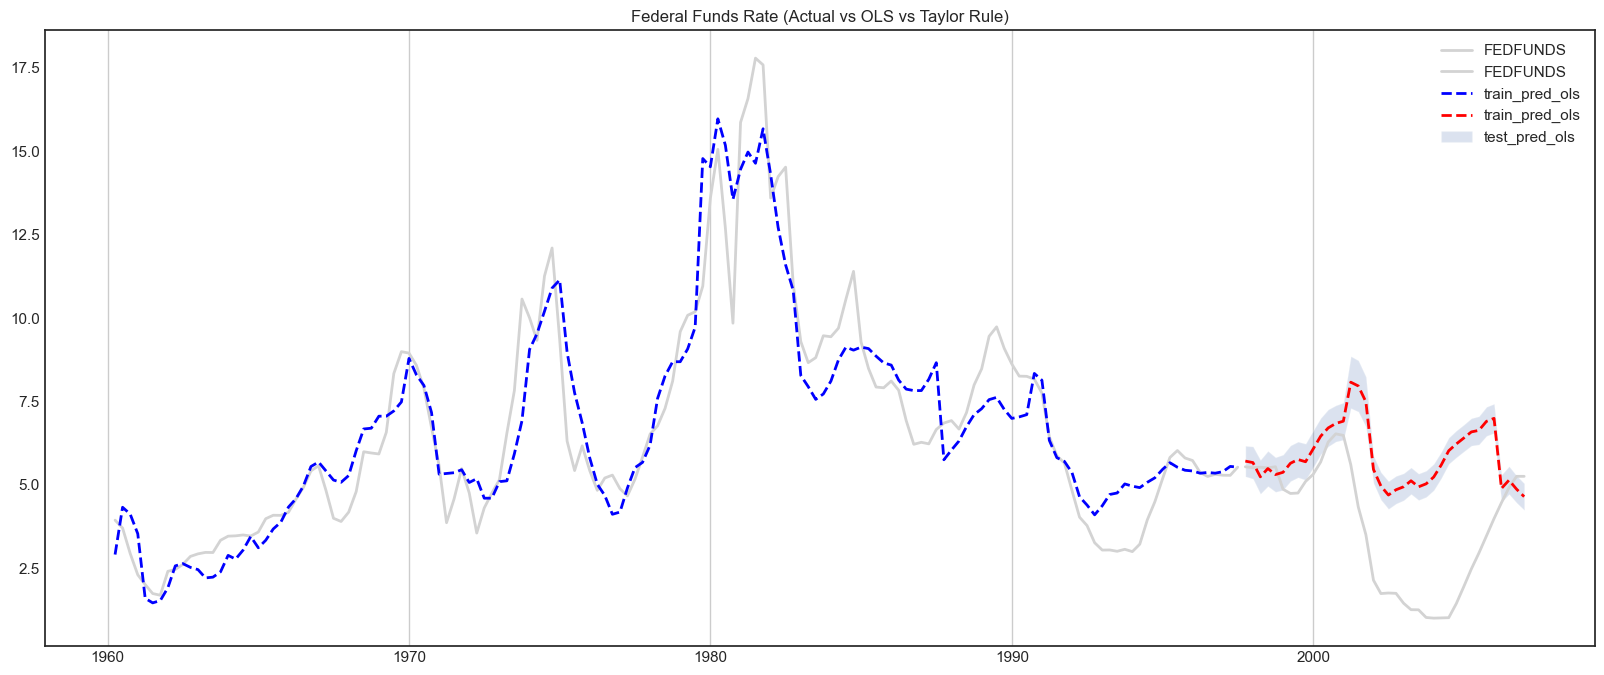

In [655]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_pred_ols.index, train_pred_ols['mean'], color='blue', linestyle='--', linewidth=2)
ax.plot(test_pred_ols.index, test_pred_ols['mean'], color='red', linestyle='--', linewidth=2)
ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_ols","train_pred_ols",'test_pred_ols',"ffef_tr"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

In [656]:
pd.DataFrame(y_test).describe()

,FEDFUNDS
count,38.000000
mean,3.739737
std,1.889039
min,0.996667
25%,1.742500
50%,4.391667
75%,5.451667
max,6.520000


In [657]:
pd.DataFrame(test_pred_ols).describe()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,5.848367,0.243054,5.367895,6.328840,3.371271,8.325464
std,0.914526,0.052632,0.845124,0.990017,0.898022,0.931330
min,4.637763,0.198918,4.238209,5.037317,2.177114,7.098412
25%,5.117899,0.204701,4.714637,5.520626,2.656719,7.579078
50%,5.648581,0.217406,5.157774,6.151751,3.167569,8.129593
75%,6.545708,0.270783,6.105398,6.993334,4.076702,9.014714
max,8.067925,0.394173,7.288719,8.847132,5.517962,10.617889


# LGBM

In [658]:
ltb_model = ltb.LGBMRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_lgbm = ltb_model.predict(X_train_trf, pred_contrib=False, raw_score=False)

<Axes: >

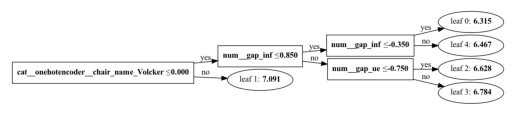

In [659]:
ltb.plot_tree(ltb_model)

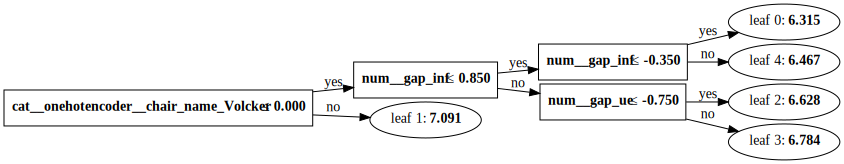

In [660]:
ltb.create_tree_digraph(ltb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

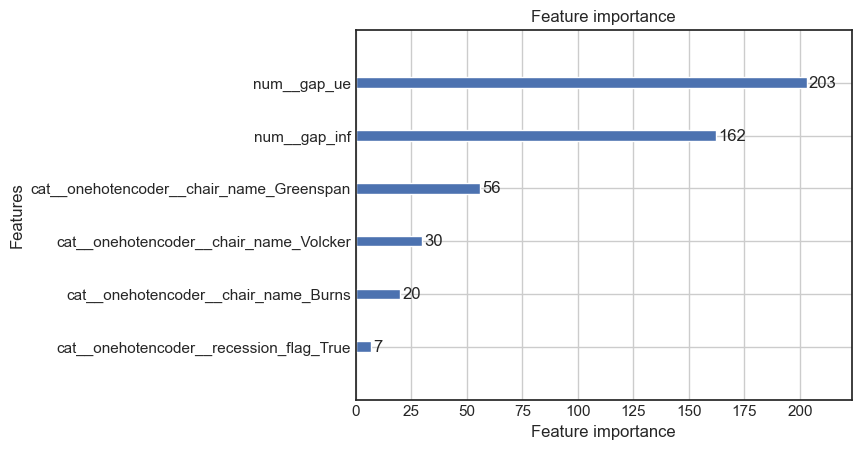

In [661]:
ltb.plot_importance(ltb_model)

In [662]:
model_results(y_train, train_pred_lgbm, X_train.shape[0], 2 )

r-squared:  0.9373
adj r-squared 0.9369
mse:  0.6813
rmse:  0.8254
rmse:  0.825406772872179


## Test

In [663]:
test_pred_lgbm = ltb_model.predict(X_test_trf, pred_contrib=False, raw_score=False)
test_pred_lgbm.shape

(38,)

In [664]:
model_results(y_test, test_pred_lgbm, X_train.shape[0], 2 )

r-squared:  -1.0992
adj r-squared -1.1134
mse:  7.2939
rmse:  2.7007
rmse:  2.7007200167416188


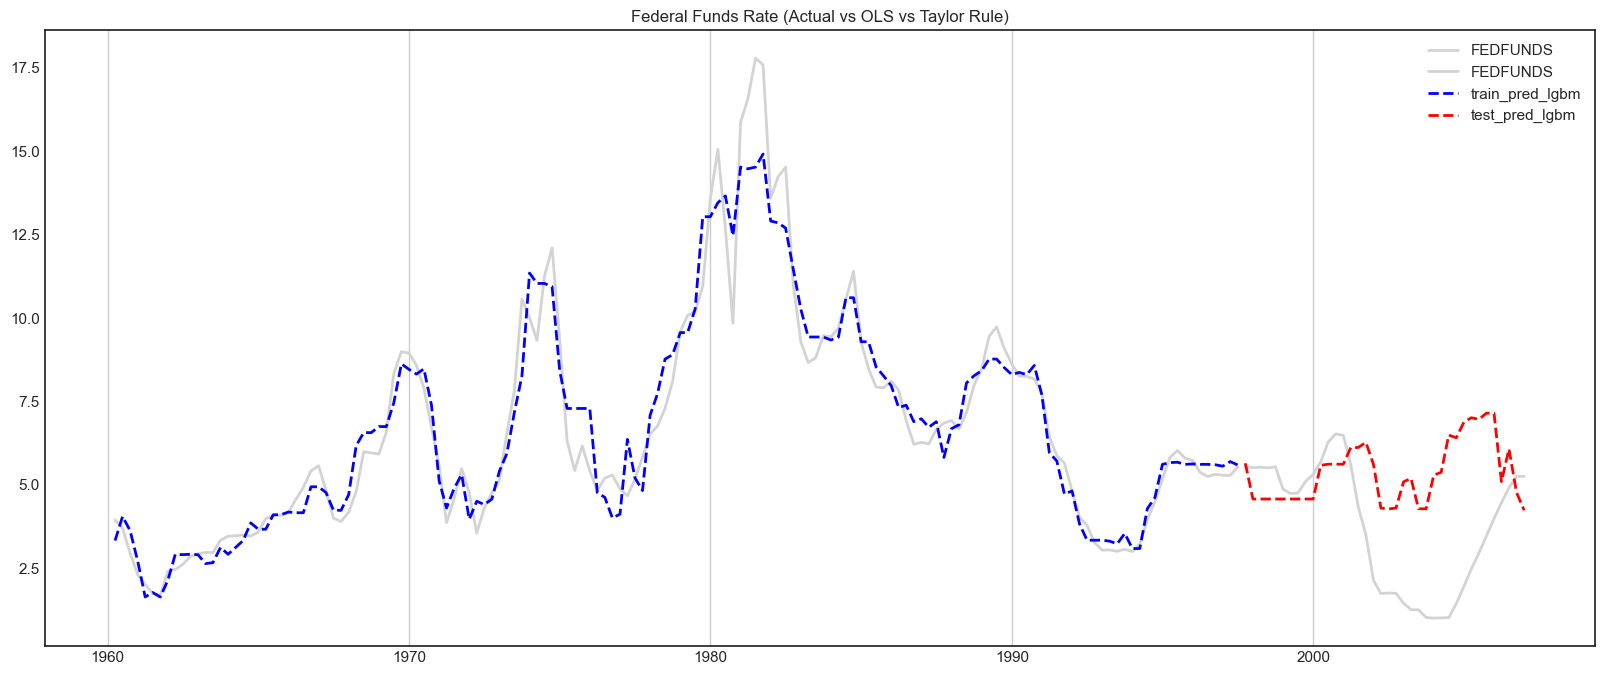

In [665]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_lgbm, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_lgbm, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# XGB

In [666]:
xgb_model = xgb.XGBRegressor(verbose=-1).fit(X_train_trf, y_train)
train_pred_xgb = xgb_model.predict(X_train_trf)
xgb_model.score(X_train_trf, y_train)

0.9998678788155094

In [667]:
model_results(y_train, train_pred_xgb, X_train.shape[0], 2 )

r-squared:  0.9999
adj r-squared 0.9999
mse:  0.0014
rmse:  0.0379
rmse:  0.03789192658452015


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

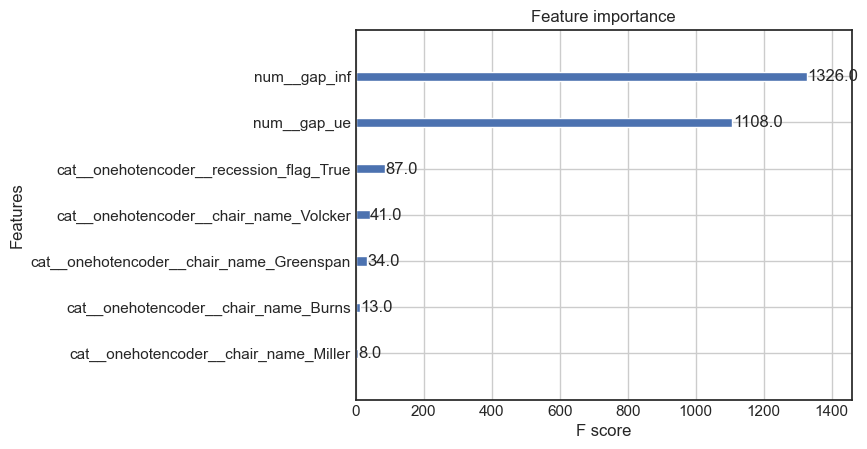

In [668]:
xgb.plot_importance(xgb_model)

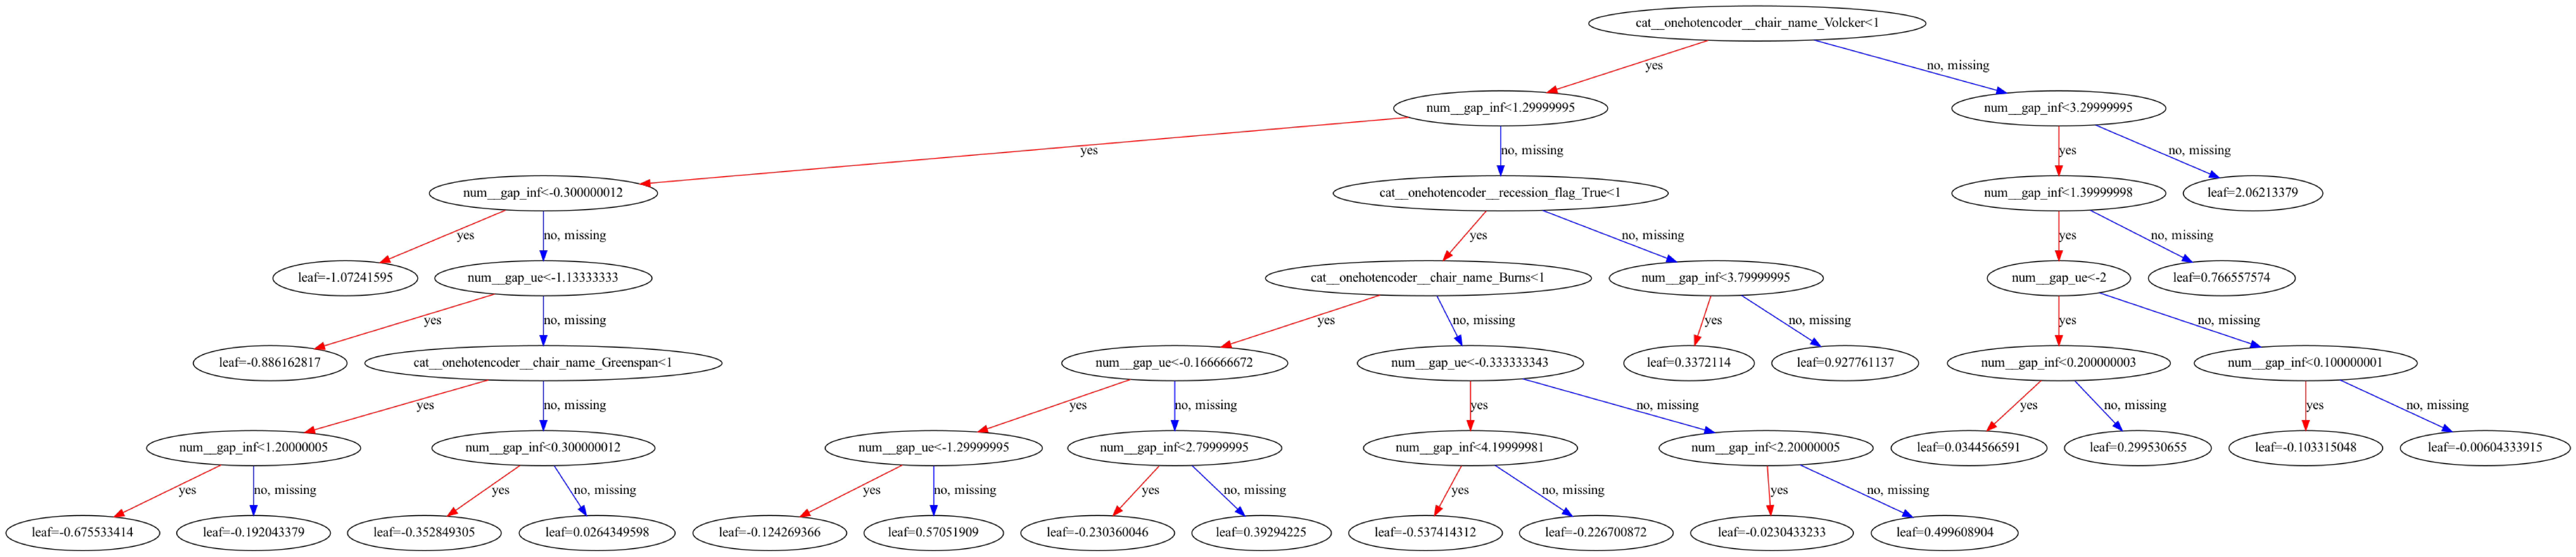

In [669]:
fig, ax = plt.subplots(figsize=(25,10))
#plt.figure(figsize=(12,12))
#xgb.plot_tree(xgb_model, ax=ax)
xgb.plot_tree(xgb_model, ax=ax,fontsize=10)

fig.set_size_inches(150, 100)
fig.savefig('tree.png')

fig.show()

## Test

In [670]:
test_pred_xgb = xgb_model.predict(X_test_trf)
test_pred_xgb.shape

(38,)

In [671]:
model_results(y_test, test_pred_xgb, X_train.shape[0], 2 )

r-squared:  -1.1369
adj r-squared -1.1513
mse:  7.4246
rmse:  2.7248
rmse:  2.7248172311990455


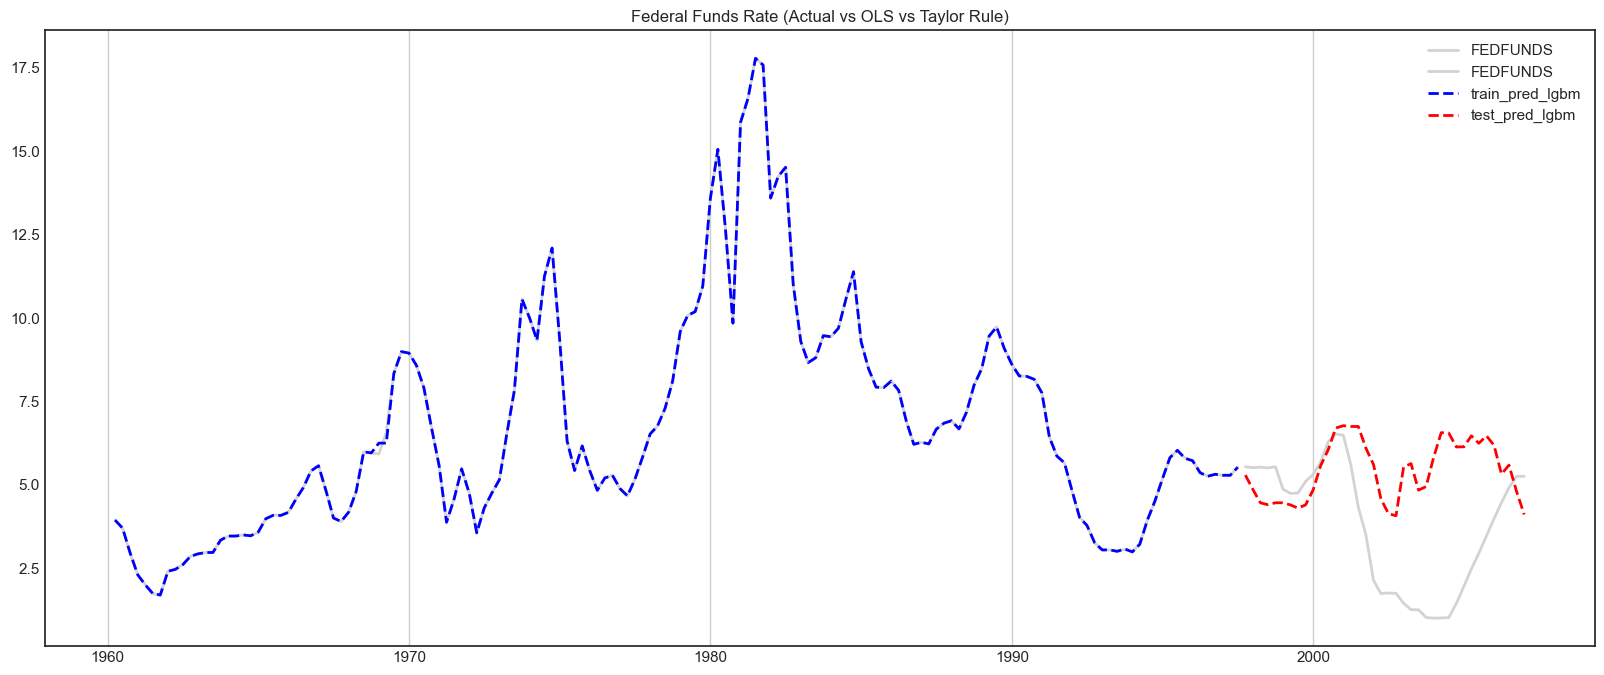

In [694]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(X_train.index, train_pred_xgb, color='blue', linestyle='--', linewidth=2)
ax.plot(X_test.index, test_pred_xgb, color='red', linestyle='--', linewidth=2)
#ax.fill_between(test_pred_ols.index, test_pred_ols['mean_ci_lower'], test_pred_ols['mean_ci_upper'], alpha=0.20)
#ax.fill_between(test_pred_ols.index, test_pred_ols['obs_ci_lower'], test_pred_ols['obs_ci_upper'], alpha=0.15)

#ax.plot(taylor_df.index, taylor_df['ffef_tr'], 'orange', linestyle='--', linewidth=1)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lgbm","test_pred_lgbm"])
ax.set(title='Federal Funds Rate (Actual vs OLS vs Taylor Rule)');

# AdaBoostRegressor

In [672]:
ada_model = AdaBoostRegressor().fit(X_train_trf, y_train)
train_pred_ada = ada_model.predict(X_train_trf)

In [673]:
model_results(y_train, train_pred_ada, X_train_trf.shape[0], 2 )

r-squared:  0.917
adj r-squared 0.9164
mse:  0.9021
rmse:  0.9498
rmse:  0.9497949757911847


In [674]:
test_pred_ada = ada_model.predict(X_test_trf)

In [675]:
model_results(y_test, test_pred_ada, X_test.shape[0], 2 )

r-squared:  -0.6499
adj r-squared -0.6958
mse:  5.7328
rmse:  2.3943
rmse:  2.394332025285118


# tsa.SARIMAX

In [731]:
taylor2006_df = load_taylor2()
taylor2006_df = taylor2006_df.query('index < "2007-01-01"')
taylor2006_df

pcep_df: (765, 2)
gdpdef_df: (302, 2)
t1_df: (336, 18)


,FEDFUNDS,PCEPILFE,GDPC1,GDPPOT,UNRATE,TB3MS,PCEPILFE_CH1,GDPDEF_PC1,rLR,GDPC1_log,GDPPOT_log,gap_gdp,gap_ue,gap_inf,ffef_tr,ffef_tr2,recession_flag,chair_name
DATE,,,,,,,,,,,,,,,,,,
1960-03-31,3.933333,15.842333,3517.181,3255.290989,5.133333,3.873333,0.327333,1.3,2.573333,8.165415,8.088037,0.077378,-0.133333,-1.672667,2.103022,1.997667,False,Martin
1960-06-30,3.696667,15.902333,3498.246,3288.916718,5.233333,2.993333,0.304333,1.4,1.593333,8.160017,8.098314,0.061703,-0.233333,-1.695667,1.080685,0.933167,True,Martin
1960-09-30,2.936667,15.964667,3515.385,3321.957785,5.533333,2.360000,0.262333,1.4,0.960000,8.164904,8.108310,0.056595,-0.533333,-1.737667,0.381797,0.086833,True,Martin
1960-12-31,2.296667,16.017000,3470.278,3353.814414,6.266667,2.306667,0.224667,1.3,1.006667,8.151990,8.117854,0.034136,-1.266667,-1.775333,0.360735,-0.289667,True,Martin
1961-03-31,2.003333,16.044333,3493.703,3385.151548,6.800000,2.350000,0.202000,1.1,1.250000,8.158717,8.127154,0.031564,-1.800000,-1.798000,0.568782,-0.347000,False,Martin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-12-31,3.980000,82.831333,16136.734,14953.145978,4.966667,3.826667,1.849667,3.3,0.526667,9.688854,9.612677,0.076177,0.033333,-0.150333,2.339255,2.317833,False,Greenspan
2006-03-31,4.456667,83.311000,16353.835,15038.784402,4.733333,4.393333,1.753000,3.2,1.193333,9.702218,9.618388,0.083830,0.266667,-0.247000,2.864748,2.956167,False,Bernanke
2006-06-30,4.906667,83.974667,16396.151,15125.706099,4.633333,4.703333,2.012667,3.4,1.303333,9.704802,9.624151,0.080651,0.366667,0.012667,3.362659,3.505667,False,Bernanke


In [732]:
train2006_df, test2006_df = time_split(taylor2006_df)

train_df:  (150, 18)
test_df:  (38, 18)


In [733]:
model_results(train2006_df['FEDFUNDS'], train2006_df['ffef_tr'], train2006_df.shape[0], 2 )

r-squared:  -0.6623
adj r-squared -0.6735
mse:  18.0647
rmse:  4.2503
rmse:  4.250257114872181


In [734]:
model_results(test2006_df['FEDFUNDS'], test2006_df['ffef_tr'], test2006_df.shape[0], 2 )

r-squared:  0.4693
adj r-squared 0.4546
mse:  1.8439
rmse:  1.3579
rmse:  1.357889672009976


In [735]:
X_train = train2006_df[['gap_inf', 'gap_ue','recession_flag','chair_name']]
X_train_trf = t_fit.transform(X_train)


y_train = train2006_df['FEDFUNDS']

In [736]:
model = sm.tsa.SARIMAX(y_train, exog=X_train_trf)

In [737]:
result_model = model.fit(disp=False)

In [738]:
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  150
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -196.756
Date:                Fri, 17 Nov 2023   AIC                            411.513
Time:                        17:15:15   BIC                            438.608
Sample:                    03-31-1960   HQIC                           422.521
                         - 06-30-1997                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2043      0.510      4.318      0.000       1.204       3.205
x2             1.5644      0.239      6.551      0.000       1.096       2.032
x3             0.3025      0.282      1.073      0.283      -0.250       0.855
x4             0.6243     31.830      0.020      0.984     -61.761      63.009
x5             0.4219     65.719      0.006      0.995    -128.384     129.228
x6             1.3225     49.673      0.027      0.979     -96.034      98.679
x7             0.8746     66.613      0.013      0.990    -129.684     131.433
ar.L1          0.9941      0.020     49.472      0.000       0.955       1.033
sigma2         0.7834      0.062     12.619      0.000       0.662       0.905
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):               428.41
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [739]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)

In [740]:
train_pred_SARIM = train_result.summary_frame()
train_pred_SARIM

FEDFUNDS,mean,mean_se,mean_ci_lower,mean_ci_upper
1960-03-31,-3.895711,8.149887,-19.869195,12.077774
1960-06-30,-3.800397,8.149887,-19.773882,12.173087
1960-09-30,-4.362300,8.149887,-20.335785,11.611184
1960-12-31,-5.592558,8.149887,-21.566043,10.380926
1961-03-31,-6.779324,8.149887,-22.752809,9.194161
...,...,...,...,...
1996-06-30,-1.487377,8.149887,-17.460861,14.486108
1996-09-30,-1.140719,8.149887,-17.114204,14.832766
1996-12-31,-1.125243,8.149887,-17.098728,14.848241
1997-03-31,-0.957782,8.149887,-16.931266,15.015703


## Test

In [741]:
X_test = test2006_df[['gap_inf', 'gap_ue','recession_flag','chair_name']]
X_test_trf = t_fit.transform(X_test)


y_test = train2006_df['FEDFUNDS']

In [742]:
s_idx = len(X_train_trf)
e_idx = s_idx + len(X_test_trf) - 1

In [743]:
test_result = result_model.get_prediction(start=s_idx, end=e_idx, exog=X_test_trf, dynamic=True)

In [744]:
test_pred_SARIM = test_result.summary_frame()
test_pred_SARIM.shape

(38, 4)

In [745]:
predict_ci = test_result.conf_int(alpha=0.5)
predict_ci.head()

,lower FEDFUNDS,upper FEDFUNDS
1997-09-30,4.761252,5.955263
1997-12-31,4.408860,6.092460
1998-03-31,4.092655,6.148559
1998-06-30,3.934994,6.301964
1998-09-30,3.754162,6.392747


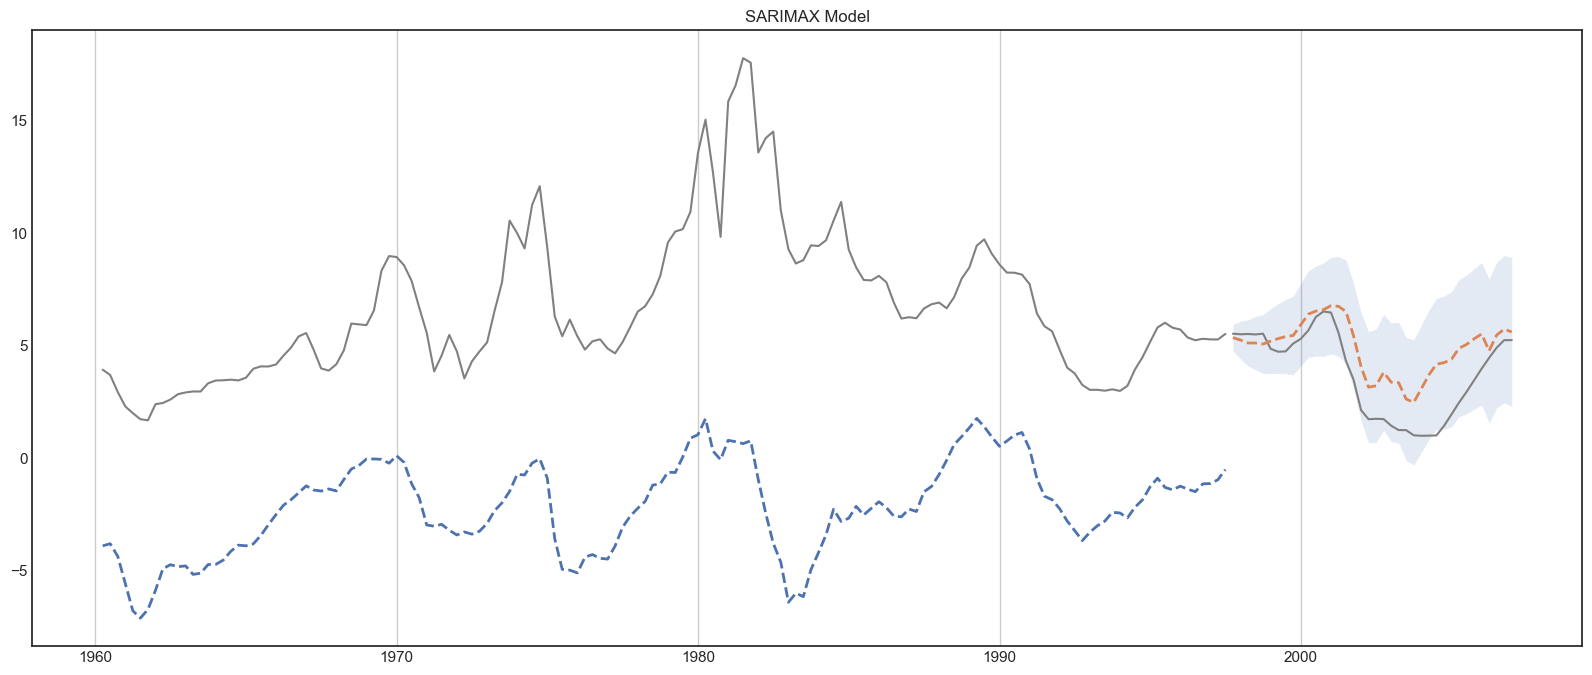

In [746]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train2006_df.index, train2006_df['FEDFUNDS'], 'gray')
ax.plot(test2006_df.index, test2006_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
ax.fill_between(test_pred_SARIM.index, predict_ci['lower FEDFUNDS'], predict_ci['upper FEDFUNDS'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [747]:
print('SARIMAX RMSE(Train):' , statsmodels.tools.eval_measures.rmse(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX RMSE(Test):' , statsmodels.tools.eval_measures.rmse(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX RMSE(Train): 9.281879385113273
SARIMAX RMSE(Test): 1.5347764067563832


In [748]:
print('SARIMAX R-Squard(Train):' , r2_score(train2006_df['FEDFUNDS'], train_pred_SARIM['mean']))
print('SARIMAX R-Squard(Test):' , r2_score(test2006_df['FEDFUNDS'], test_pred_SARIM['mean']))

SARIMAX R-Squard(Train): -6.927767872856268
SARIMAX R-Squard(Test): 0.32206186594707875
